## Background

Pearson resiudals transform raw UMI counts into a representation where:

- remove technical variation that comes from differences in total counts between cells
- stabilize the mean-variance relationship across genes
- genes that are homogenously expressed have small variance, while genes that are differntially expressed have high variance.

Computing Pearson residuals replace the steps of explicitly normalizing by sequencing depth and log-transforming the data for variance stabilization. These are similar to Seurat's `scTransfrom` model.

### Preparations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


### Load data

Load the donwloaded datasets from disk and create `AnnData` objects for them.

In [2]:
adata_pbmc3k = sc.read_10x_mtx("tutorial_data/pbmc3k_v1/", cache=True)
adata_pbmc10k = sc.read_10x_mtx("tutorial_data/pbmc10k_v3/", cache=True)

adata_pbmc3k.uns["name"] = "PBMC 3k (v1)"
adata_pbmc10k.uns["name"] = "PBMC 10k (v3)"

... reading from cache file cache/tutorial_data-pbmc3k_v1-matrix.h5ad
... reading from cache file cache/tutorial_data-pbmc10k_v3-matrix.h5ad


Demonstrate that Pearson residuals select meaningful genes on these datasets by comparing gene selection to a set of marker genes identified in the PBMC3k tutorial.

A good gene selection should include these differentially expressed genes.

In [3]:
# marker genes from table in pbmc3k tutorial
markers = [
    "IL7R",
    "LYZ",
    "CD14",
    "MS4A1",
    "CD8A",
    "GNLY",
    "NKG7",
    "FCGR3A",
    "MS4A7",
    "FCER1A",
    "CST3",
    "PPBP",
]

## Perform quality control

Remove cells and genes with few counts, then remove outlier cells.

### Basic filtering

In [4]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    adata.var_names_make_unique()
    print(adata.uns["name"], ": data shape:", adata.shape)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

PBMC 3k (v1) : data shape: (2700, 32738)
filtered out 19024 genes that are detected in less than 3 cells
PBMC 10k (v3) : data shape: (11769, 33538)
filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


### Compute quality control metrics

Compute the number of detected genes per cell, total counts per cell and percentage of MT- genes per cell.

In [5]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )

### Plot quality control metrics

Plot all metrics and observe some outlier cells in both datasets.

PBMC 3k (v1) :


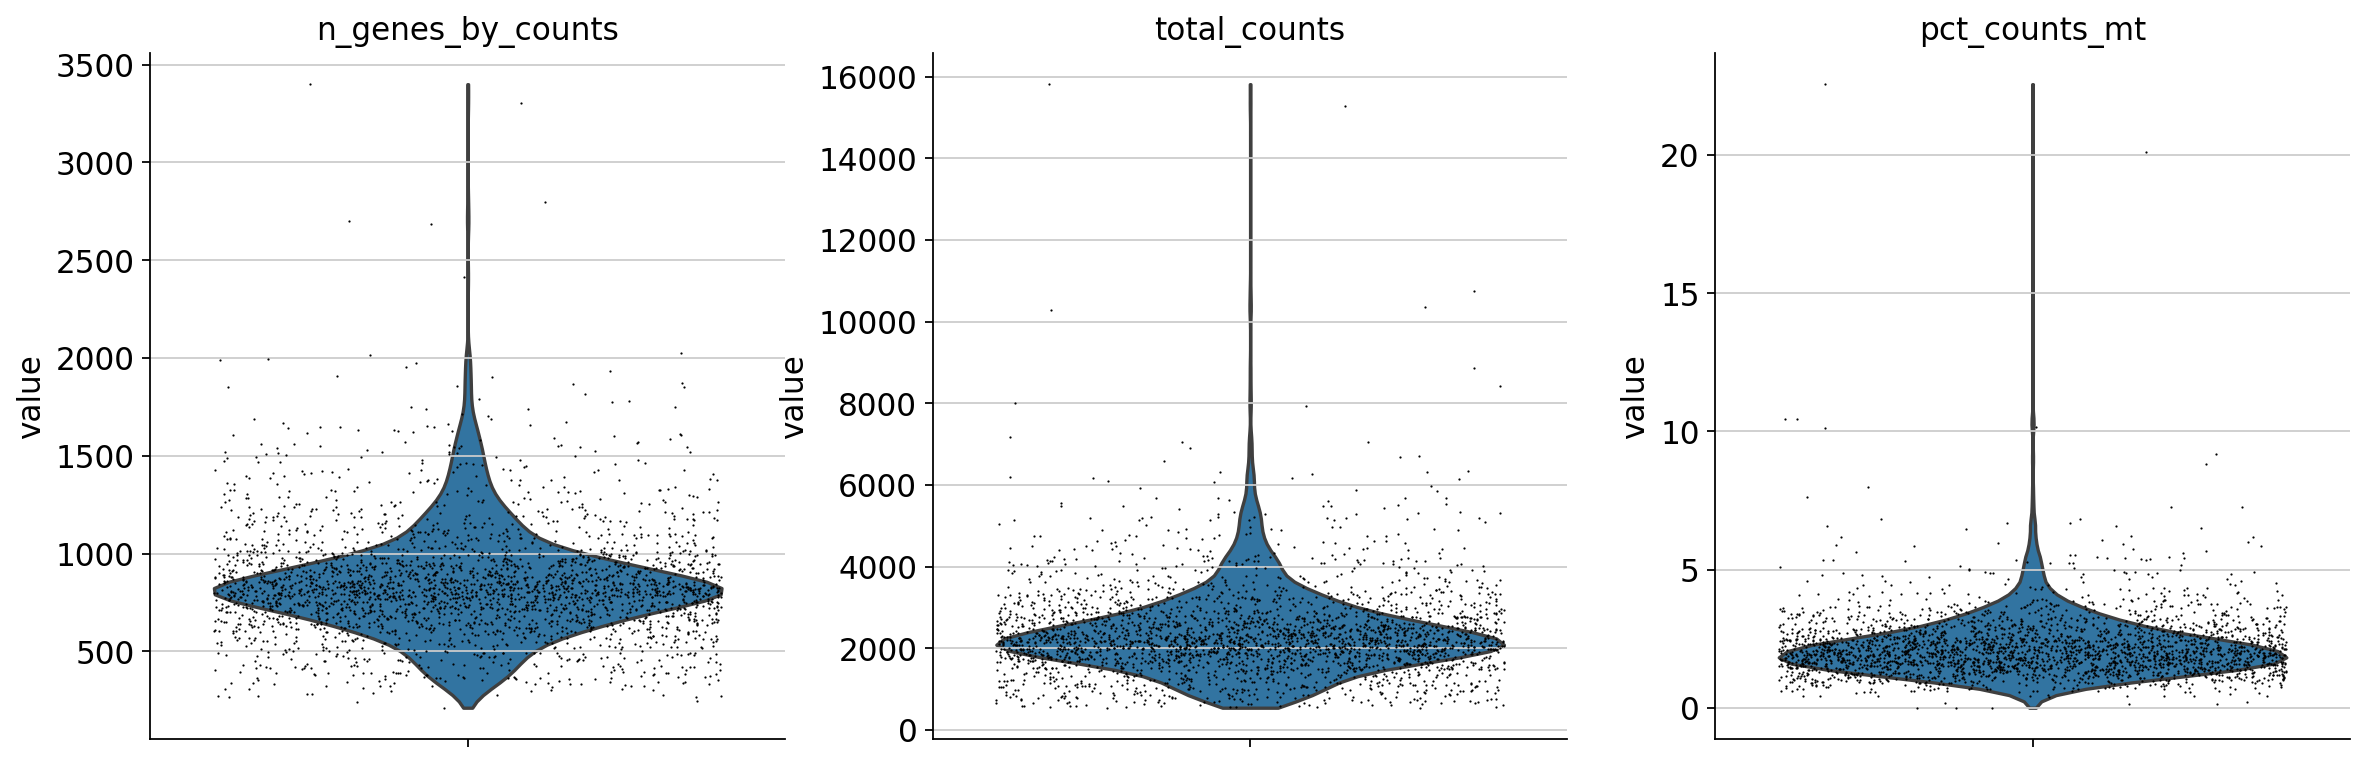

PBMC 10k (v3) :


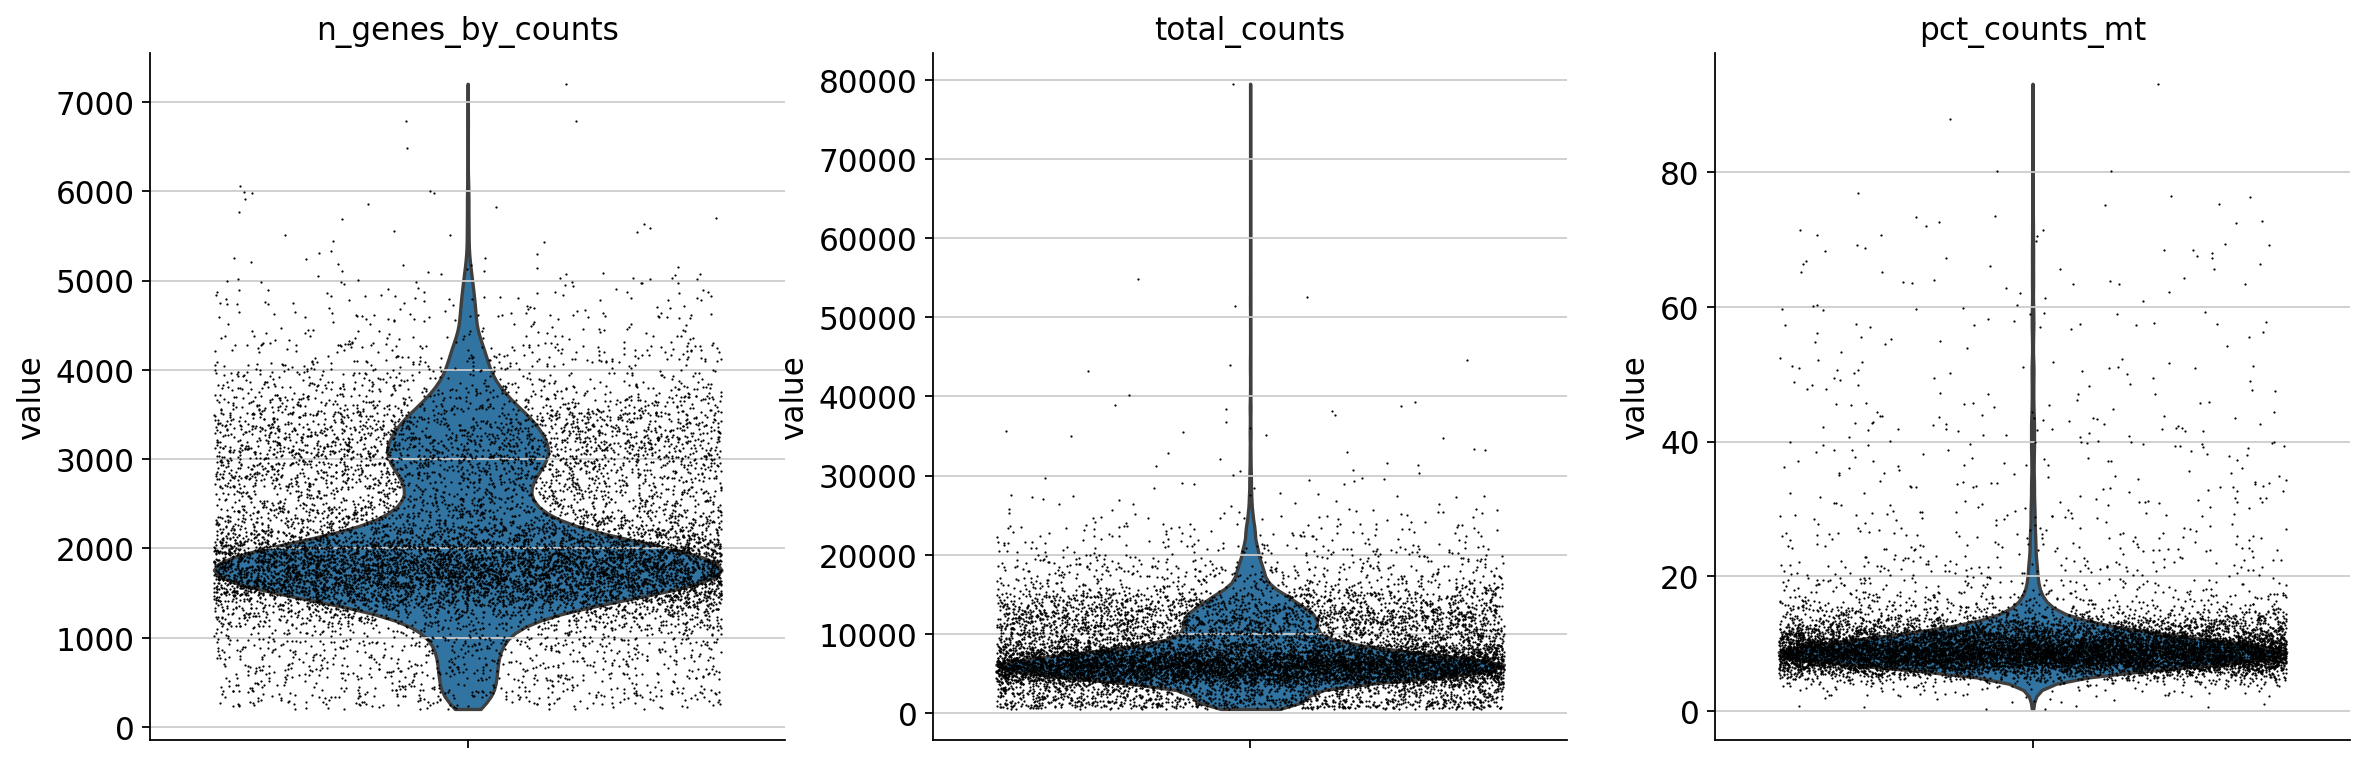

In [6]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )

Based on these metrics, define outlier cells and remove them. Make sure that all genes are at least detected once in the remaining cells.

In [7]:
# define outliers and do the filtering for the 3k dataset
adata_pbmc3k.obs['outlier_mt'] = adata_pbmc3k.obs.pct_counts_mt > 5
adata_pbmc3k.obs['outlier_total'] = adata_pbmc3k.obs.total_counts > 5000
adata_pbmc3k.obs['outlier_genes'] = adata_pbmc3k.obs.n_genes_by_counts > 25000

print('%u cells with high %% of mitochondrial genes' % (sum(adata_pbmc3k.obs['outlier_mt'])))
print('%u cells with large total counts' % (sum(adata_pbmc3k.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(adata_pbmc3k.obs['outlier_genes'])))

adata_pbmc3k = adata_pbmc3k[~adata_pbmc3k.obs['outlier_mt'], :]
adata_pbmc3k = adata_pbmc3k[~adata_pbmc3k.obs['outlier_total'], :]
adata_pbmc3k = adata_pbmc3k[~adata_pbmc3k.obs['outlier_genes'], :]
sc.pp.filter_genes(adata_pbmc3k, min_cells=1)

57 cells with high % of mitochondrial genes
69 cells with large total counts
0 cells with large number of genes
filtered out 2 genes that are detected in less than 1 cells


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [8]:
# define outliers and do the filtering for the 10k dataset
adata_pbmc10k.obs['outlier_mt'] = adata_pbmc10k.obs.pct_counts_mt > 20
adata_pbmc10k.obs['outlier_total'] = adata_pbmc10k.obs.total_counts > 25000
adata_pbmc10k.obs['outlier_ngenes'] = adata_pbmc10k.obs.n_genes_by_counts > 6000

print('%u cells with high %% of mitochondrial genes' % (sum(adata_pbmc10k.obs['outlier_mt'])))
print('%u cells with large total counts' % (sum(adata_pbmc10k.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(adata_pbmc10k.obs['outlier_ngenes'])))

adata_pbmc10k = adata_pbmc10k[~adata_pbmc10k.obs['outlier_mt'], :]
adata_pbmc10k = adata_pbmc10k[~adata_pbmc10k.obs['outlier_total'], :]
adata_pbmc10k = adata_pbmc10k[~adata_pbmc10k.obs['outlier_ngenes'], :]
sc.pp.filter_genes(adata_pbmc10k, min_cells=1)

494 cells with high % of mitochondrial genes
75 cells with large total counts
6 cells with large number of genes
filtered out 1 genes that are detected in less than 1 cells


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


## Use Pearson residuals for selction of highly variable genes

Analytic Pearson residuals can be used to identify biologically variable genes. For that, the observed counts are compared to the expected counts of a “null model”. This model includes no biological variability between cells. Pearson residuals are defined such that genes that are not differentially expressed will have variance close to 1. In contrast, if a gene is differentially expressed, it will deviate from the null model, causing larger residuals and residual variance >1 for this gene.

`highly_variable_genes(flavor='pearson_residuals', n_top_genes=2000)` computes the residual variances and selects 2000 genes based on this. Cell type marker genes are successfully selected. 

### Compute 2000 variable genes with Pearson residuals
 
 This will create the field `highly_variable`, indicating the 2000 genes that have the most variable Pearson residuals.

In [9]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=2000
    )

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


### Plot gene selection

Plot the mean and residual variance of each gene,highlighting the selected genes (red). On top, plot the known marker genes defined in the beginning (black). All of them are selected.

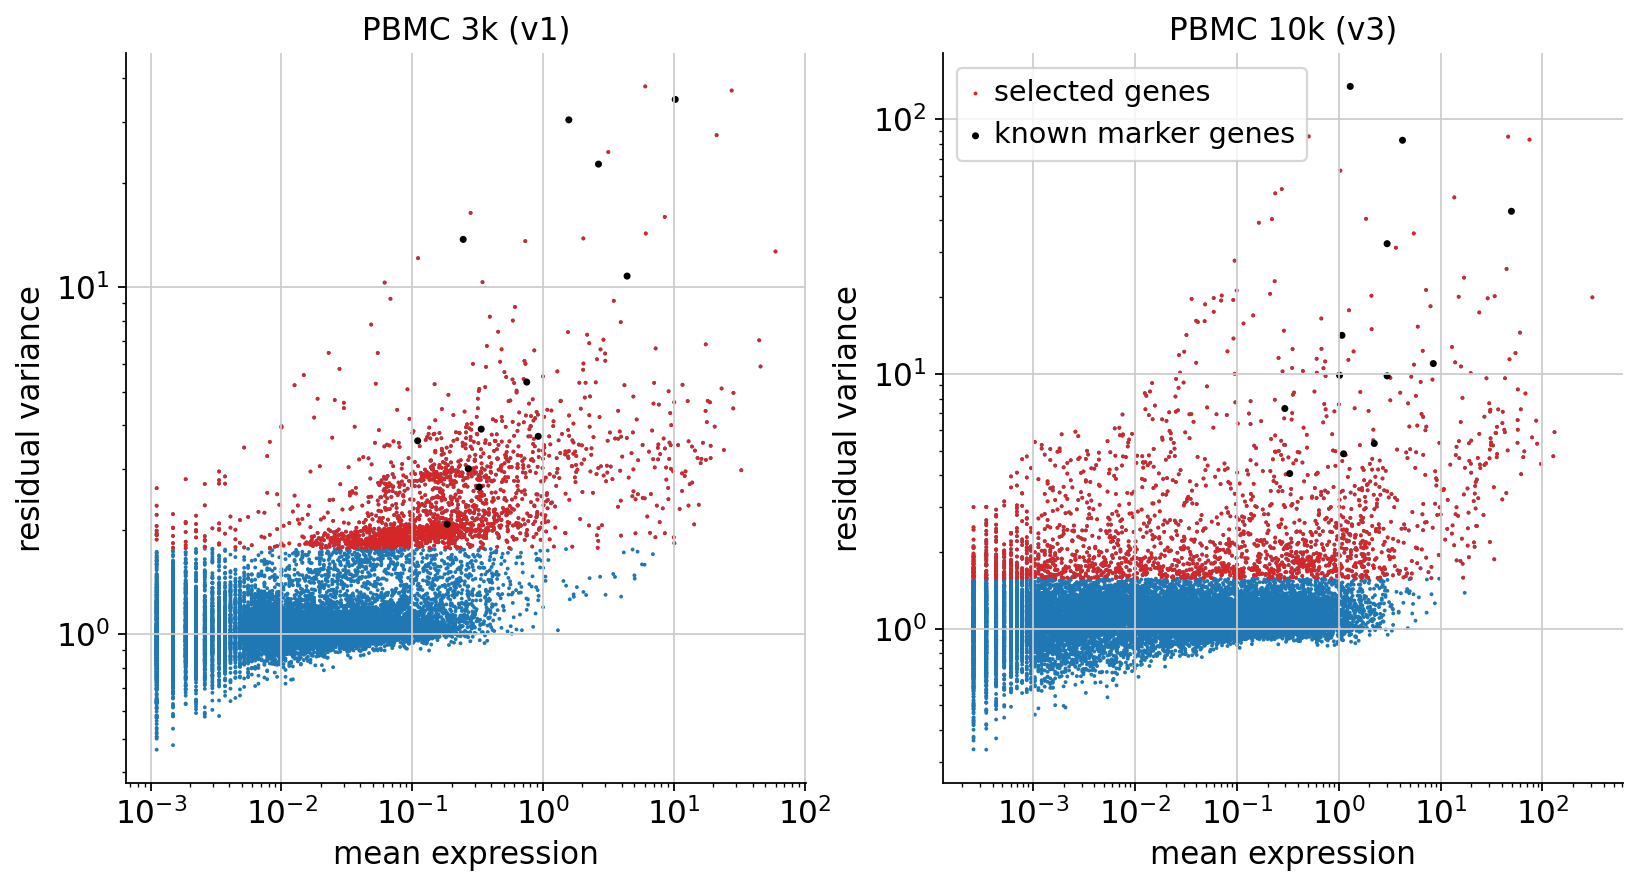

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, adata in zip(axes, [adata_pbmc3k, adata_pbmc10k]):
    
    hvgs = adata.var["highly_variable"]
    
    ax.scatter(
        adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
    )
    ax.scatter(
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
    ax.scatter(
        adata.var["mean_counts"][np.isin(adata.var_names, markers)],
        adata.var["residual_variances"][np.isin(adata.var_names, markers)],
        c="k",
        label="known marker genes",
        s=10,
        edgecolor="none",
    )
    ax.set_xscale("log")
    ax.set_xlabel("mean expression")
    ax.set_yscale("log")
    ax.set_ylabel("residual variance")
    ax.set_title(adata.uns["name"])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
plt.legend()

### Apply gene selection

Subset both datasets to retain just the variable genes.

In [11]:
adata_pbmc3k = adata_pbmc3k[:, adata_pbmc3k.var["highly_variable"]]
adata_pbmc10k = adata_pbmc10k[:, adata_pbmc10k.var["highly_variable"]]

### Print resulting `adata` objects

In [12]:
adata_pbmc3k

View of AnnData object with n_obs × n_vars = 2574 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'outlier_mt', 'outlier_total', 'outlier_genes'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'name', 'hvg'

In [13]:
adata_pbmc10k

View of AnnData object with n_obs × n_vars = 10968 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'outlier_mt', 'outlier_total', 'outlier_ngenes'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'name', 'hvg'

## Transforming raw counts to Pearson residuals

The observed UMI counts are compared to the expected counts of a "null model". The model includes only technical factors, but no biological differences between cells. Keep only the deviations from this model, the _residuals_, as representaion of the data. This implicitly performs normalization by sequencing depth and variance stabilization.

The transformed data will show less technical variability, and biological signals from variable genes will be amplified. Downstream processing like PCA will be dominated by biological variances rather than technical variances.

After reducing the datasets to the most variable genes in the previous steps, we will transfrom the raw counts by residuals by calling `normalize_pearson_residuals(adata)`. In this pipeline, apply PCA to reduce the dataset to the most relevant dimensions, visualize the reduced representation with t-SNE and perform Leiden clustering.

After PCA, you could also use UMAP or other embeddings to inspect the data, and cluster the data with a different algorithm than Leiden.

### Preparations

First save a copy of the raw counts to `adata.layers['raw']`. Also, save a depth-normalized and square-toor transformed version of the data to `adata.layers['sqrt_norm']`, so they can be used for plotting normalized counts later. 

In [14]:
# keep raw and depth-normalized counts for later
adata_pbmc3k.layers["raw"] = adata_pbmc3k.X.copy()
adata_pbmc3k.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_pbmc3k, inplace=False)["X"]
)

adata_pbmc10k.layers["raw"] = adata_pbmc10k.X.copy()
adata_pbmc10k.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_pbmc10k, inplace=False)["X"]
)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/tmp/ipykernel_391/4284728622.py:2: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata_pbmc3k.layers["raw"] = adata_pbmc3k.X.copy()
/tmp/ipykernel_391/4284728622.py:7: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata_pbmc10k.layers["raw"] = adata_pbmc10k.X.copy()


### Compute Pearson residuals

This will transform the sparse raw counts in `adata.X` to a dense matrix of Pearson residuals.

In [15]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.experimental.pp.normalize_pearson_residuals(adata)

computing analytic Pearson residuals on adata.X
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


### Compute PCA and t-SNE

Reduce the dimensionality of the data by running PCA on the Pearson residuals. On top, we run t-SNE for visualization

In [16]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.pp.pca(adata, n_comps=50)
    n_cells = len(adata)
    sc.tl.tsne(adata, use_rep="X_pca")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:04)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:20)


### Compute Neighborhood graph and Leiden clustering

Based on the PCA of Pearson residuals, we can also run a clustering.

In [17]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
    sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


### Plot Leiden clusters on tSNE and PBMC marker genes

Show clustering results on the top of the t-SNE. Also, show the normalized counts of each marker gene on hte same t-SNE. This demonstrates that the clusters found in the Pearson residuals + PCA data representation coincides with 'islands' of known markers.

PBMC 3k (v1) :


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


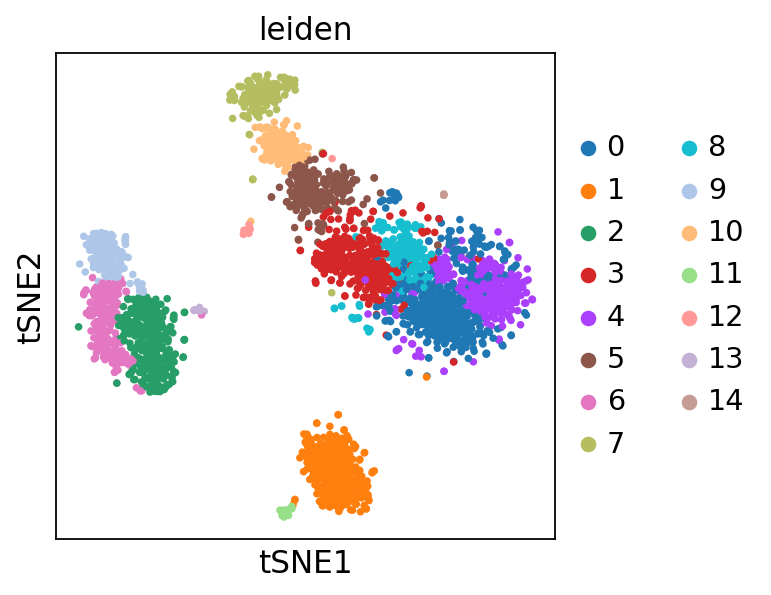

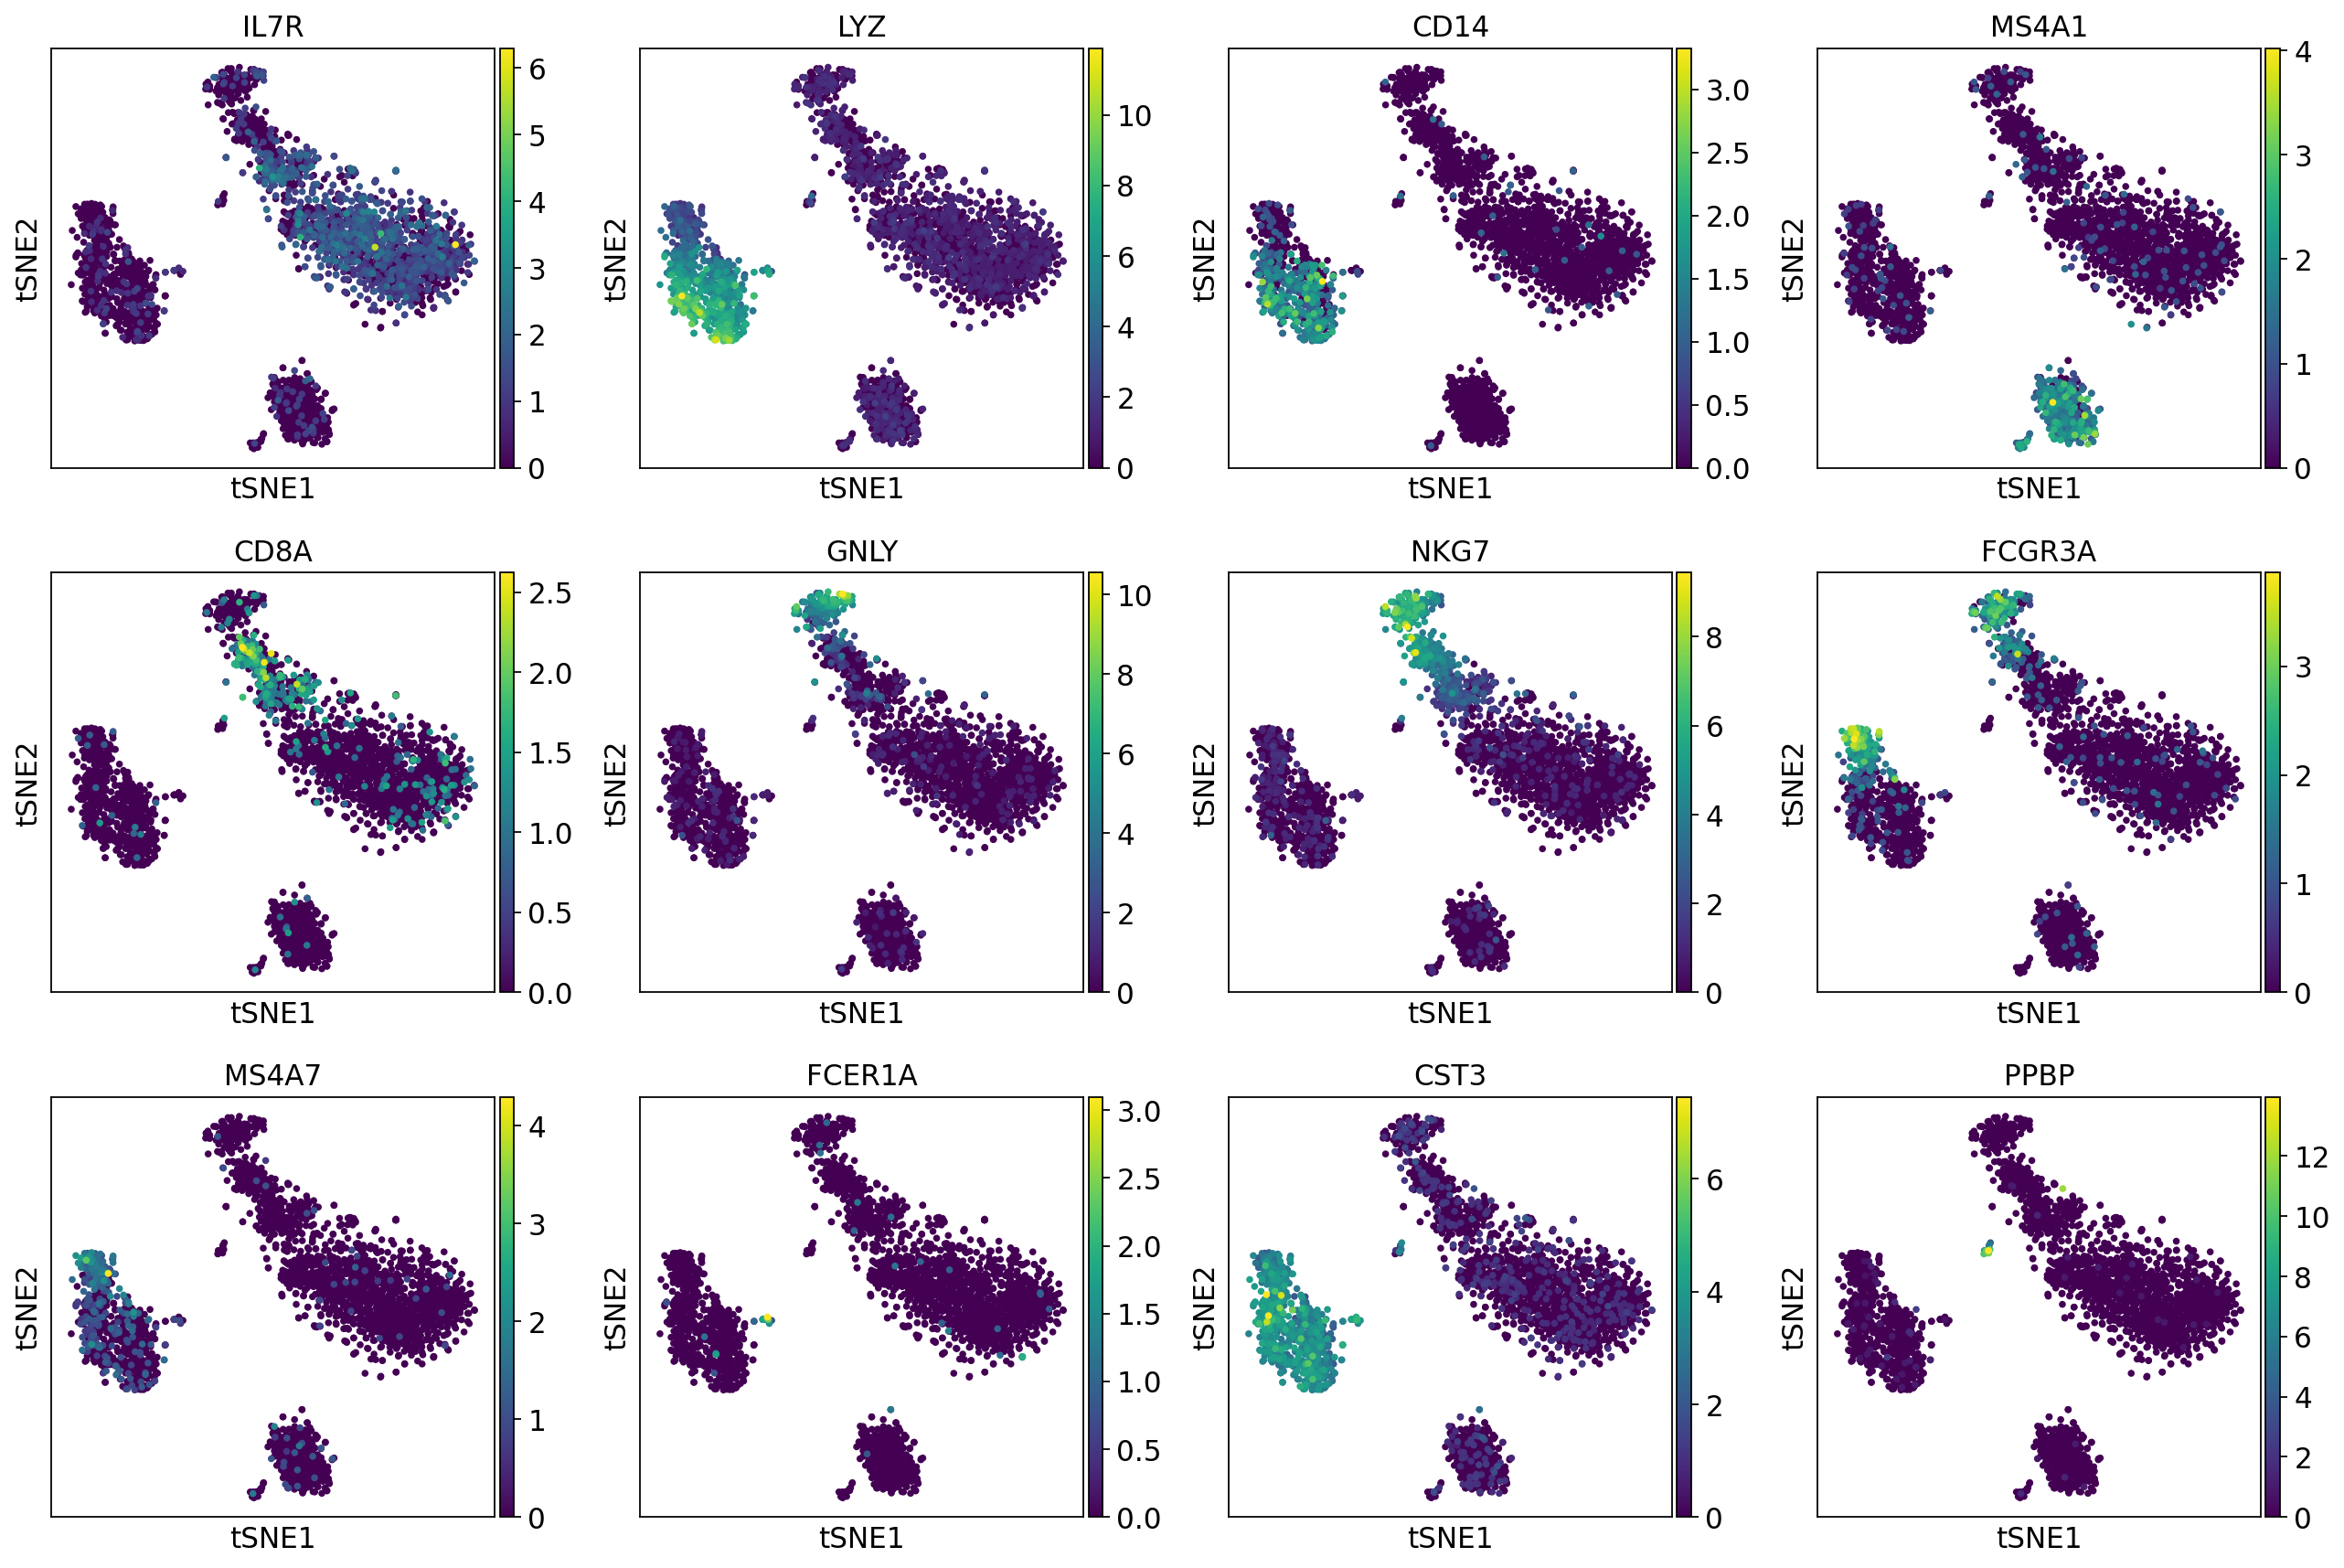

PBMC 10k (v3) :


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


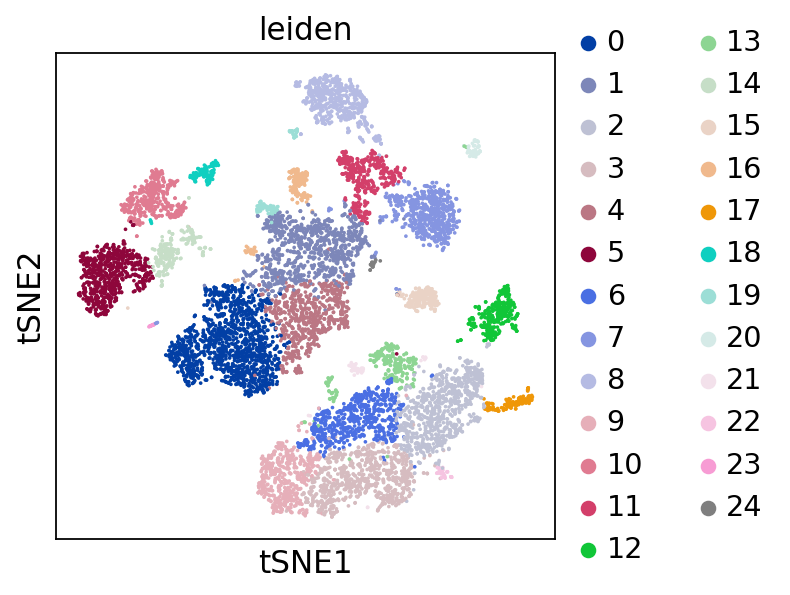

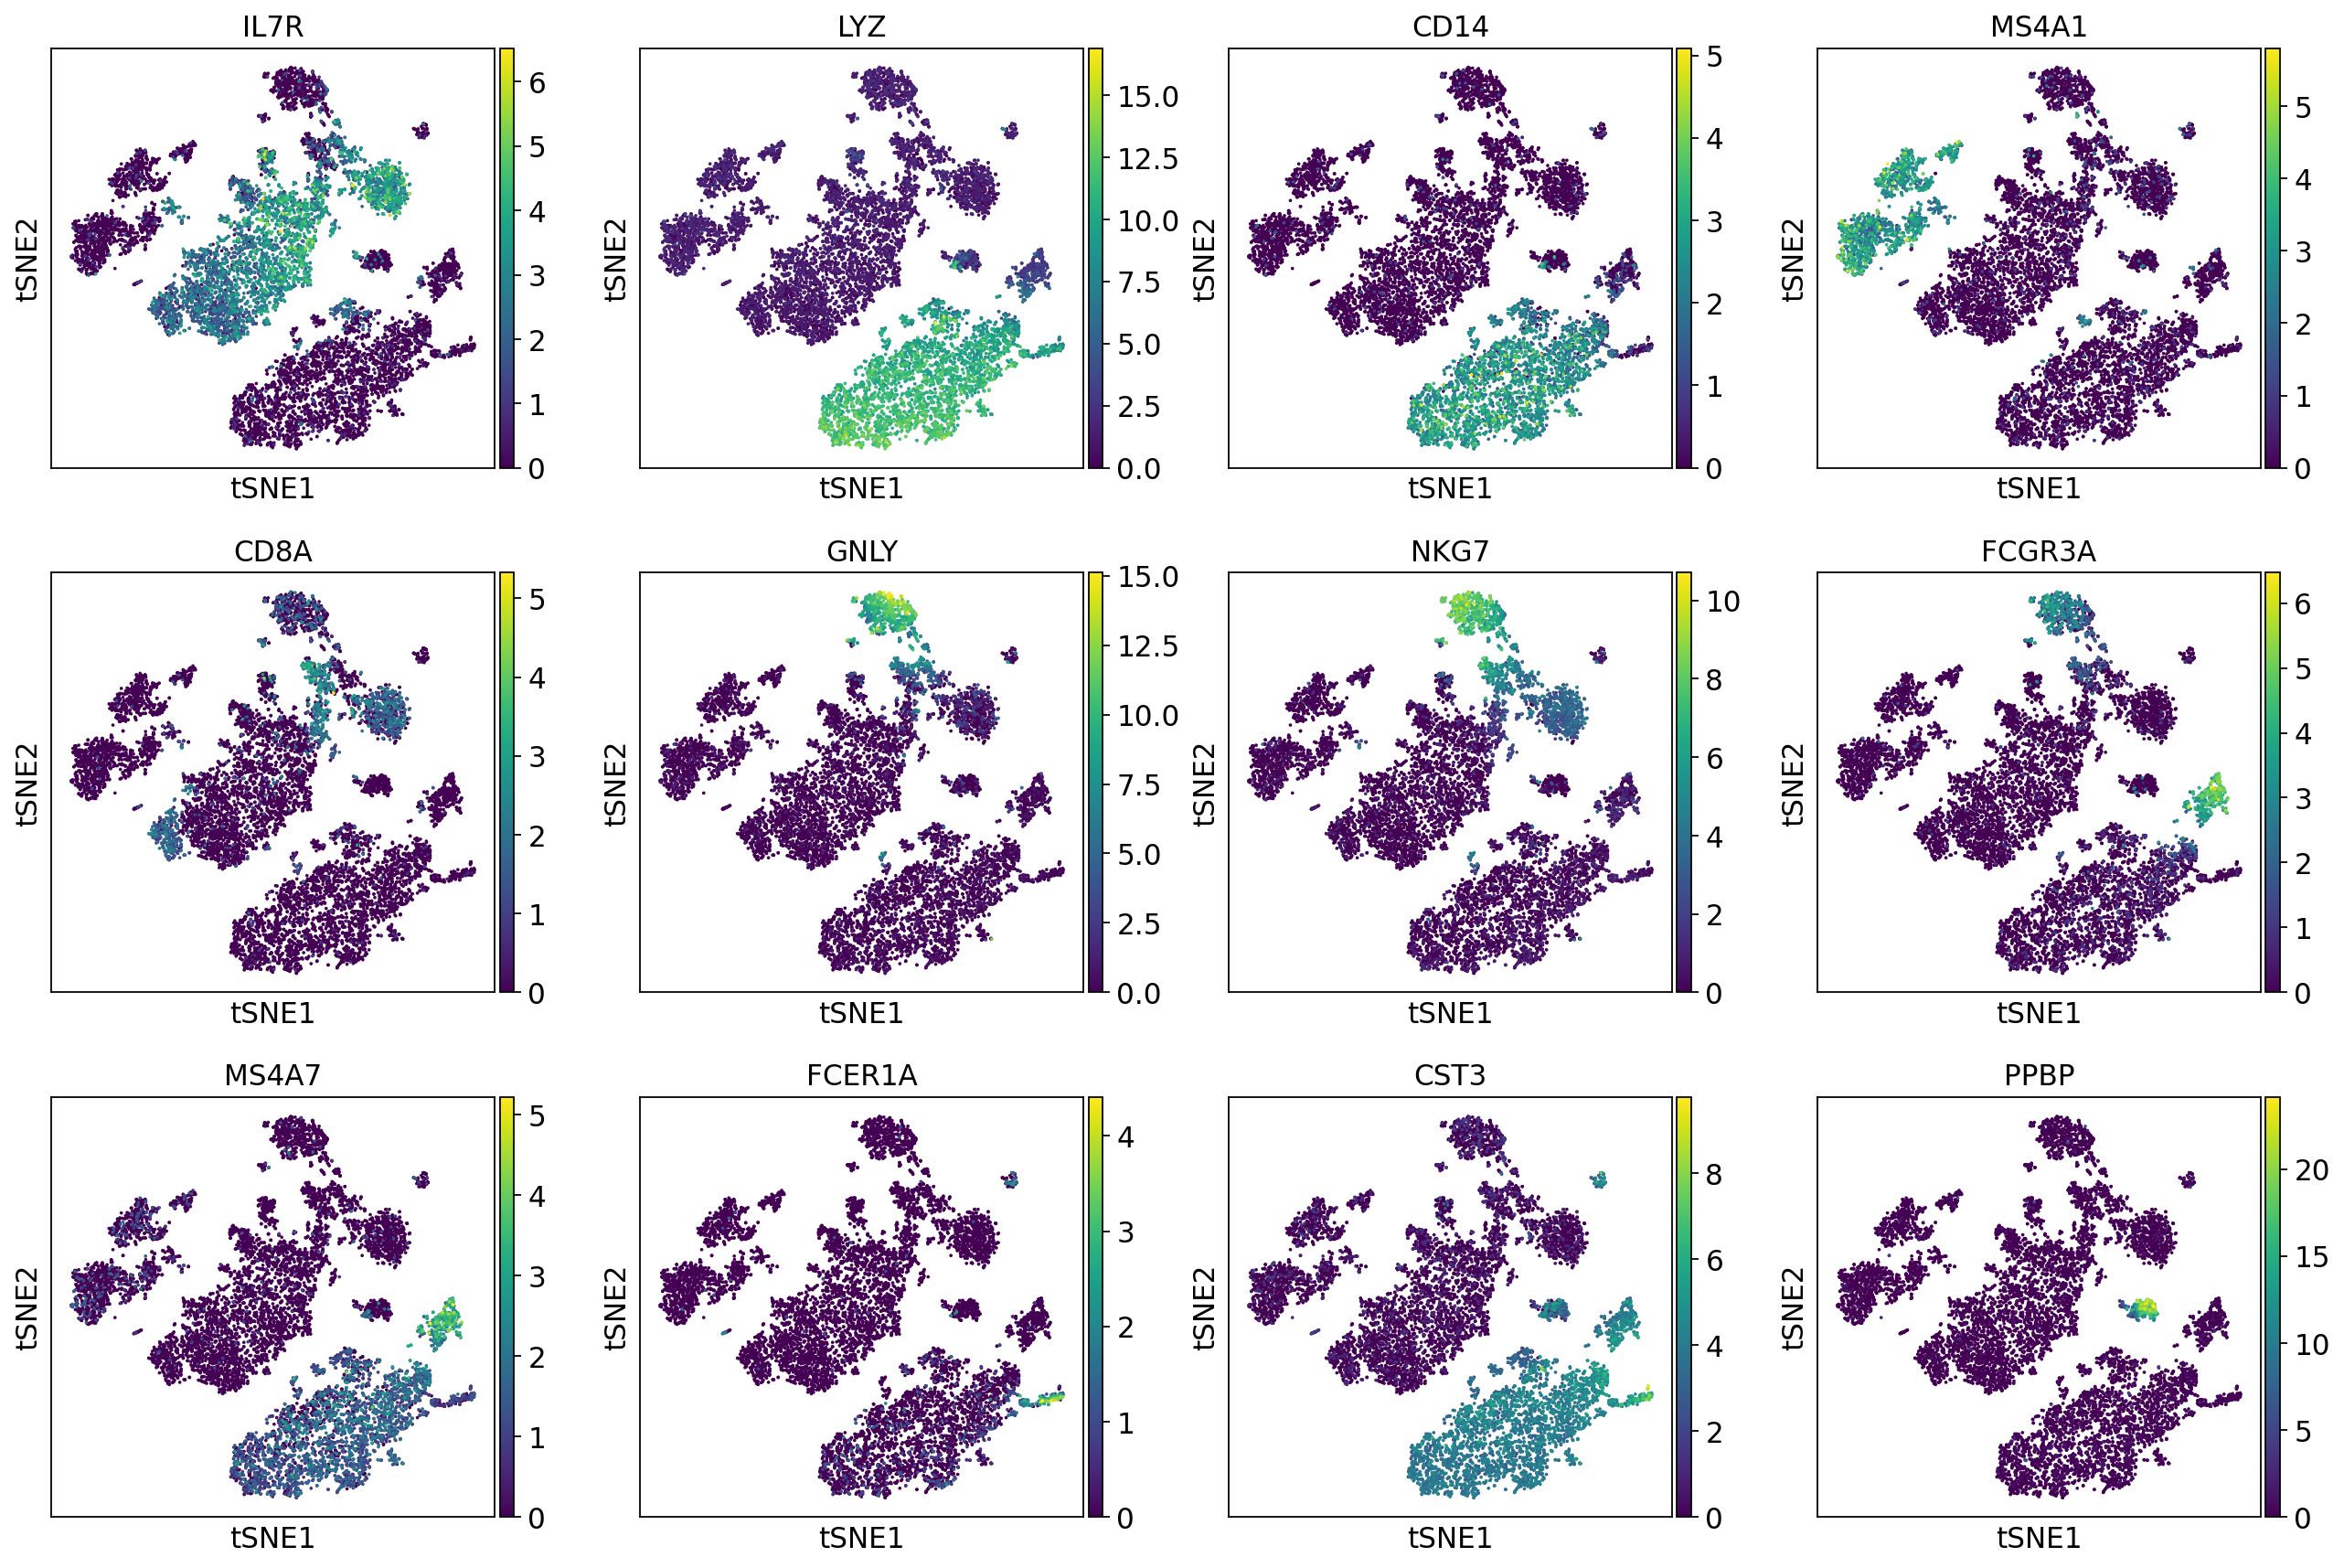

In [18]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    sc.pl.tsne(adata, color=["leiden"], cmap="tab20")
    sc.pl.tsne(adata, color=markers, layer="sqrt_norm")